<a href="https://colab.research.google.com/github/kyomaland/image_cnns/blob/master/Cassava_build_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#For accessing Google Cloud Store
!pip install gcsfs

In [2]:
import math, os, re, warnings, random
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#from kaggle_datasets import KaggleDatasets
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics, layers
#import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

from sklearn.model_selection import train_test_split
from functools import partial
from keras.callbacks import Callback


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
REPLICAS = strategy.num_replicas_in_sync
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.1
INFO:tensorflow:Initializing the TPU system: grpc://10.3.85.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.85.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [3]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512, 512]
#IMAGE_SIZE = [224, 224]
BATCH_SIZE = 8 * REPLICAS 
LEARNING_RATE = 1e-4 * REPLICAS #1e-5
EPOCHS = 100 #30
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 5
ES_PATIENCE = 10 #5
N_FOLDS = 5

def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


#database_base_path = '/content/input/raw'
##database_base_path = '/tmp/kaggle-data'
###training_path = '/tmp/kaggle-data'
###train = pd.read_csv(f'{database_base_path}/train.csv')
###print(f'Train samples: {len(train)}')

#GCS_PATH = training_path
#GCS_PATH = get_gcs_path()
#GCS_PATH = 'gs://kds-7edb6b200570e03505c2c8b51546e17bfef2e493ee048343ac8fd722'
GCS_PATH = 'gs://kds-5aa0bc7b16935d65ef6334184486ee9ab86d9e404dfad4bd4c32200c'
print(GCS_PATH)
print("#####")

print(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')
#GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification') # Original dataset
# GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-{HEIGHT}x{WIDTH}') # Only resized
##GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT}x{WIDTH}') # Center croped and resized

#TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec') # Original TFRecords
##TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')

TRAINING_FILENAMES, VALIDATION_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'), test_size=0.2, random_state=42) #test_size=0.35

###TEST_FILENAMES = tf.io.gfile.glob(database_base_path + '/ld_test*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)


print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
##display(train.head())

CLASSES = ['Bacterial Blight', 
           'Brown Streak', 
           'Green Mottle', 
           'Mosaic Disease', 
           'Healthy']

gs://kds-5aa0bc7b16935d65ef6334184486ee9ab86d9e404dfad4bd4c32200c
#####
gs://kds-5aa0bc7b16935d65ef6334184486ee9ab86d9e404dfad4bd4c32200c/train_tfrecords/ld_train*.tfrec
GCS: train images: 16045


# Visualisation

In [4]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(50,50))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Model evaluation, for K-FOLD
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()


# Augmentation

In [5]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = 0
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image


# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image    

# Auxilliary Functions

In [6]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# Data Handling Functions

In [7]:
def decode_image1(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)  # image format uint8 [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image, label

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum
"""   
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name
"""
##

"""
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset
"""

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def data_augment1(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = -(-NUM_TRAINING_IMAGES // BATCH_SIZE)
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = (NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))
print(STEPS_PER_EPOCH, VALIDATION_STEPS)

Dataset: 16045 training images, 5352 validation images, 1 unlabeled test images
251 84


#Data Visualisation

In [8]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
Training data label examples: [4 3 4 ... 0 3 0]
Validation data shapes:
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
Validation data label examples: [3 3 4 ... 3 3 3]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


In [9]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [10]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

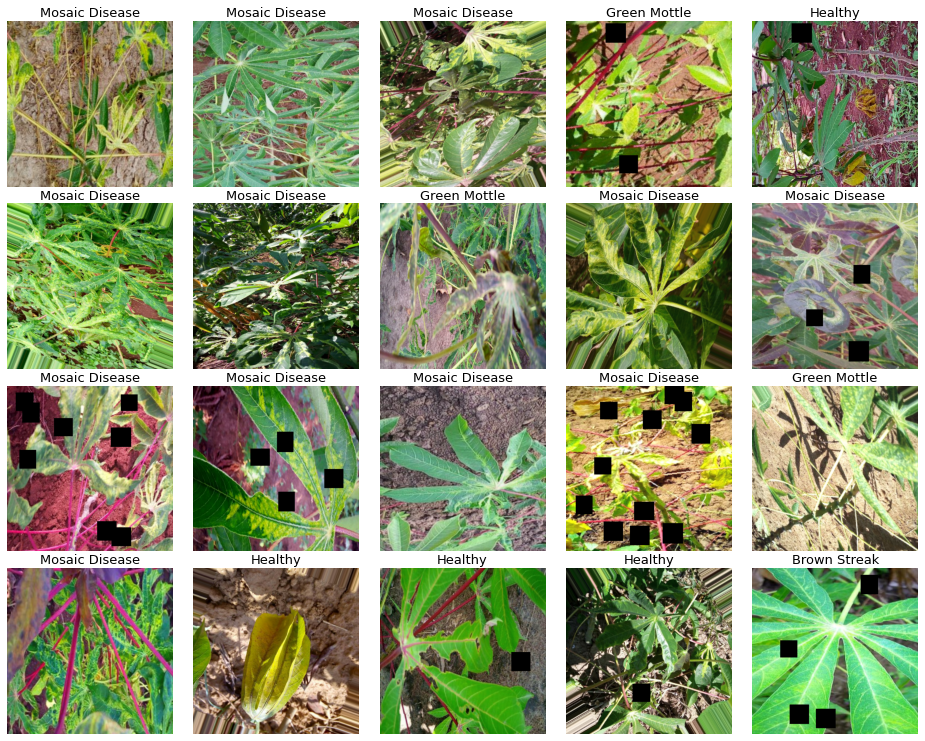

In [11]:
display_batch_of_images(next(train_iter))

In [12]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(1)
test_batch = iter(test_dataset)

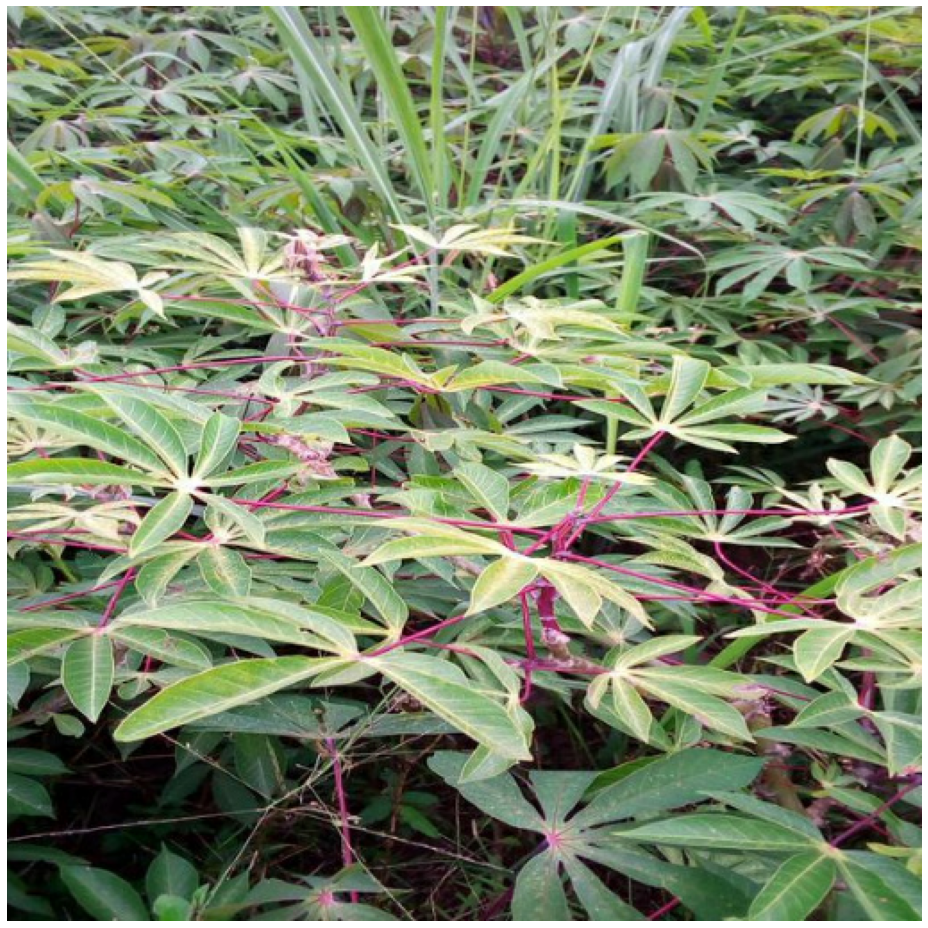

In [13]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

#Label Distribution

Train samples: 21397


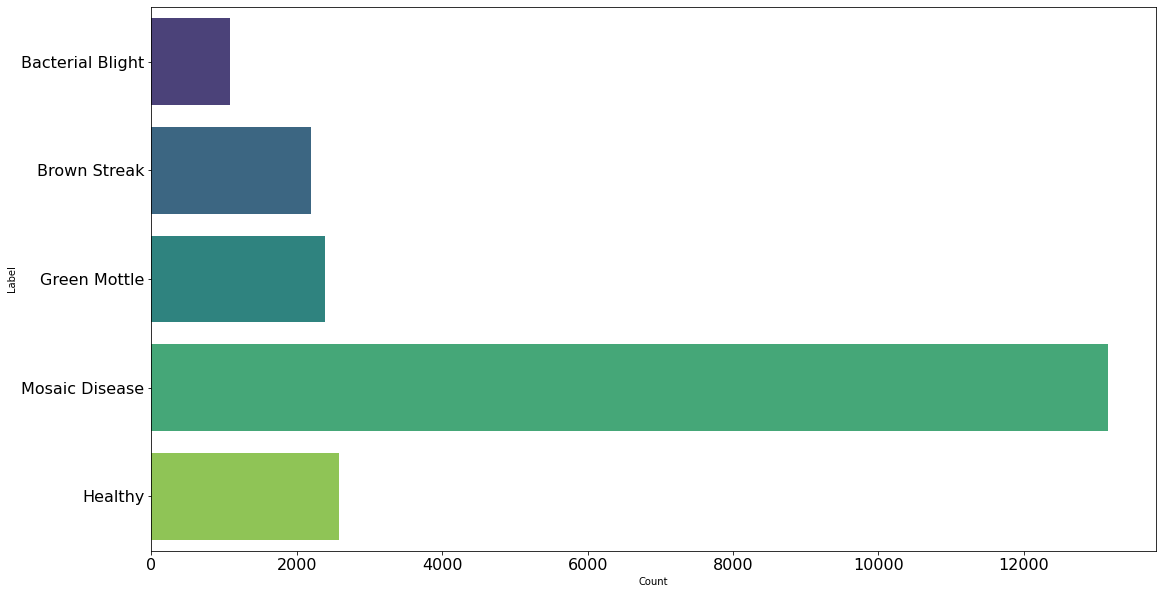

In [14]:
train = pd.read_csv(f'{GCS_PATH}/train.csv')
print(f'Train samples: {len(train)}')
label_count = train.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

#Balancing the data

In [15]:
total_images = label_count['Count'].sum()
print(total_images)
#print(count_data_items(TRAINING_FILENAMES) + count_data_items(VALIDATION_FILENAMES))
#TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
label_count['weights'] = (1 / label_count['Count']) * (total_images) / 5.0
#label_count['weights2'] = (total_images) /((label_count['Count']) * 5.0)
#weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0
print(label_count)
class_weight = dict(zip(label_count.index, label_count.weights))
print(f'The weights are {class_weight}')

21397
              Label  Count   weights
0  Bacterial Blight   1087  3.936891
1      Brown Streak   2189  1.954957
2      Green Mottle   2386  1.793546
3    Mosaic Disease  13158  0.325232
4           Healthy   2577  1.660613
The weights are {0: 3.9368905243790246, 1: 1.954956601187757, 2: 1.7935456831517183, 3: 0.3252317981456148, 4: 1.660613116026387}


#Learning Rate

In [16]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max',
                       #patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', mode='auto',
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=2) #'val_loss'


# Save the model with the minimum validation loss
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "Cassava_new_best_model.h5",
        save_best_only=True,
        monitor='sparse_categorical_accuracy',
        mode='auto')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='sparse_categorical_accuracy', #'val_loss'
        factor=0.3,
        patience=3,#2
        #min_lr=1e-12,
        mode='auto',
        verbose=2,
    )

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#The Model

In [17]:
def conv_block(filters, inputs):
  x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
  x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
  x = layers.BatchNormalization()(x)
  outputs = layers.MaxPool2D()(x)

  return outputs

def dense_block(units, dropout_rate, inputs):
  x = layers.Dense(units, activation="relu")(inputs)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dropout(dropout_rate)(x)
  return outputs

In [18]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)#0.2

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.2, x) #0.7
    x = dense_block(128, 0.2, x) #0.5
    x = dense_block(64, 0.1, x)#0.2

    outputs = layers.Dense(5, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [
        ['sparse_categorical_accuracy'],
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), #learning_rate=lr_schedule 
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy'],
        steps_per_execution = 251, #125
    )
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 256, 256, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 256, 256, 32)      1344  

In [20]:
history = model.fit(get_dataset(TRAINING_FILENAMES, ordered=False, augment=True).repeat(), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=get_dataset(VALIDATION_FILENAMES, ordered=False, augment=False).repeat(), 
                    validation_steps=VALIDATION_STEPS,
                    #class_weight=class_weight,
                    callbacks=[es, checkpoint_cb, reduce_lr] 
                    )  

Epoch 1/100
251/251 [==============================] - 86s 341ms/step - loss: 1.5925 - sparse_categorical_accuracy: 0.3980 - val_loss: 1.2221 - val_sparse_categorical_accuracy: 0.6122
Epoch 2/100
251/251 [==============================] - 57s 226ms/step - loss: 1.1931 - sparse_categorical_accuracy: 0.5939 - val_loss: 1.4541 - val_sparse_categorical_accuracy: 0.6125
Epoch 3/100
251/251 [==============================] - 58s 230ms/step - loss: 1.1214 - sparse_categorical_accuracy: 0.6116 - val_loss: 1.1203 - val_sparse_categorical_accuracy: 0.6133
Epoch 4/100
251/251 [==============================] - 61s 242ms/step - loss: 1.0827 - sparse_categorical_accuracy: 0.6175 - val_loss: 15.3113 - val_sparse_categorical_accuracy: 0.0456
Epoch 5/100
251/251 [==============================] - 57s 227ms/step - loss: 1.0625 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.9403 - val_sparse_categorical_accuracy: 0.2029
Epoch 6/100
251/251 [==============================] - 58s 231ms/step - loss: 1

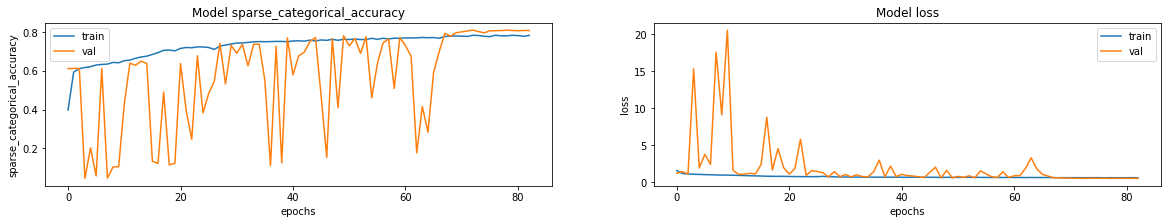

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "sparse_categorical_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [22]:
#cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
cmdataset = get_dataset(VALIDATION_FILENAMES, ordered=True,augment=False) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch NUM_VALIDATION_IMAGES 8000
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (5352,) [0 3 0 ... 3 4 3]
Predicted labels:  (5352,) [4 3 3 ... 3 1 3]


In [23]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

f1 score: 0.657, precision: 0.701, recall: 0.628


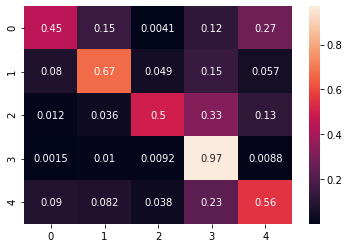

In [24]:
ax1 = plt.subplot()
sns.heatmap(cmat, annot=True,ax=ax1)
#ax1.set_xticklabels(['']+CLASSES)
#ax1.set_yticklabels(['']+CLASSES)
#plt.show()

In [25]:
#dataset = get_validation_dataset()
dataset = get_dataset(VALIDATION_FILENAMES)
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

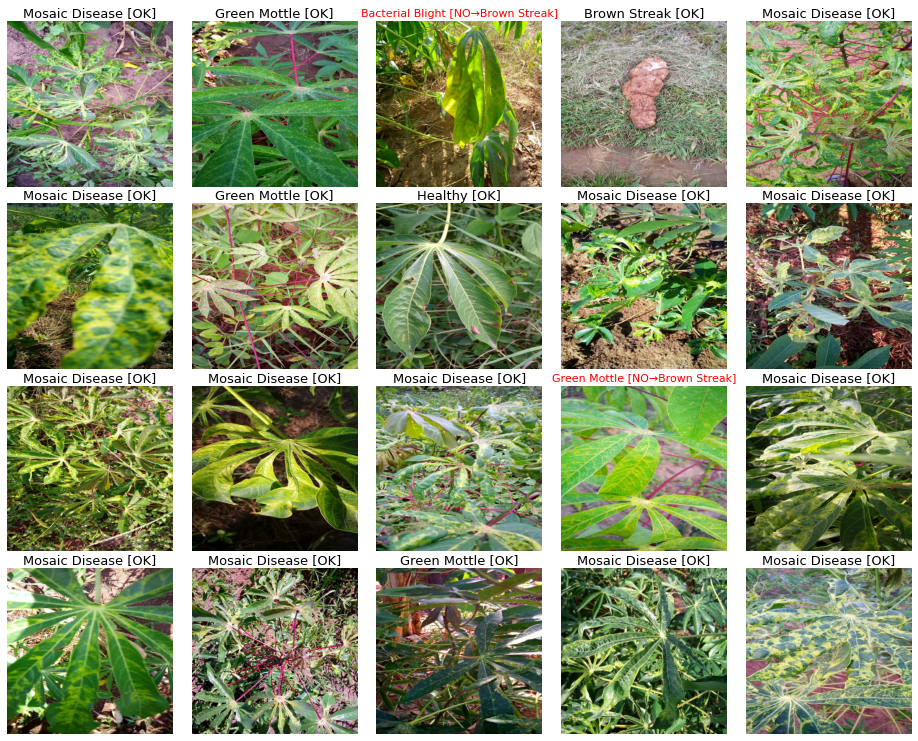

In [26]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(tf.cast(images, tf.float32))
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)